Here is just a way to query some data from OpenEO

In [1]:
# Import required packages
import openeo
from openeo.processes import process

# Connect to the back-end
connection = openeo.connect("https://openeo.cloud").authenticate_oidc()
#https://openeo.cloud
# ToDo: Here you need to authenticate with authenticate_basic() or authenticate_oidc()


Authenticated using refresh token.


In [9]:
load1 = connection.load_collection(collection_id = "SENTINEL2_L2A", bands = ["B04", "B03", "B02","B08","SCL"], spatial_extent = {"east": 8.961145817369813,
          "north": 44.4366991352135,
          "south": 44.373626699814,
          "west": 8.837940236377976}, 
                                   temporal_extent = ["2022-10-01T00:00:00Z", "2022-11-10T00:00:00Z"] ,
                                   max_cloud_cover=70
                                   )
load1=load1.process("mask_scl_dilation", data=load1, scl_band_name="SCL")

/home/driesj/python/openeo-python-client/openeo/rest/connection.py:1162: UserWarning: SENTINEL2_L2A property filtering with properties that are undefined in the collection metadata (summaries): eo:cloud_cover.
  return DataCube.load_collection(


We run the UDF on a patch size of 64x64 pixels, which is what our model expects.
If you want to test this locally, make sure to retrieve a netCDF with a single timestamp, and a size of 64x64 pixels.

In [26]:
ships = load1.apply_neighborhood(
    process=openeo.UDF.from_file("ship_inference.py"),
    size=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
        {"dimension": "t", "value": "P1D"}
    ]    ,
    overlap=[]
).rename_labels("bands",["prediction"])

In [ ]:
ships.execute_batch("test.nc")

0:00:00 Job 'vito-j-2d03430e798542059e6240d99e5294a8': send 'start'


In [3]:
%time job = load1.execute_batch(title="S2 bands of Genoa", description="Required bands for ship detection", out_format="NETCDF")

0:00:00 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': send 'start'
0:00:17 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': queued (progress N/A)
0:00:23 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': queued (progress N/A)
0:00:29 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': queued (progress N/A)
0:00:37 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': queued (progress N/A)
0:00:47 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': queued (progress N/A)
0:01:00 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': queued (progress N/A)
0:01:15 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': running (progress N/A)
0:01:35 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': running (progress N/A)
0:01:59 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': running (progress N/A)
0:02:30 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': running (progress N/A)
0:03:07 Job 'vito-j-3ceb0ce2946a4d578c8309aec0d8d56b': finished (progress N/A)
CPU times: user 54.1 ms, sys: 10.6 ms, total: 64.7 ms
Wall time: 3min 9s


In [4]:
results = job.get_results()
results.download_files("./validation_data")

[PosixPath('validation_data/openEO.nc'),
 PosixPath('validation_data/job-results.json')]

The only requirement is to feed the model  with a path to : 
    - A netCDF file that contains the necessary bands (B02, B03, B04 and B08)
    OR
    - A folder that contains the bands as single TIFFs 

Example for TIFFs format : 

2023-10-18 15:21:51.323842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 15:21:52.158532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


All bands loaded successfully.
Raw shape of the dataset was (1126, 1351, 6)
New shape is (1088, 1344)


/home/sbehloul/mambaforge/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
2023-10-18 15:22:57.576290: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-10-18 15:22:57.576378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: eohpc-scigpu1
2023-10-18 15:22:57.576384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: eohpc-scigpu1
2023-10-18 15:22:57.576749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2023-10-18 15:22:57.576789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.104.5
2023-10-18 15:22:57.576793: I tensorflow/

357/357 [===========================]


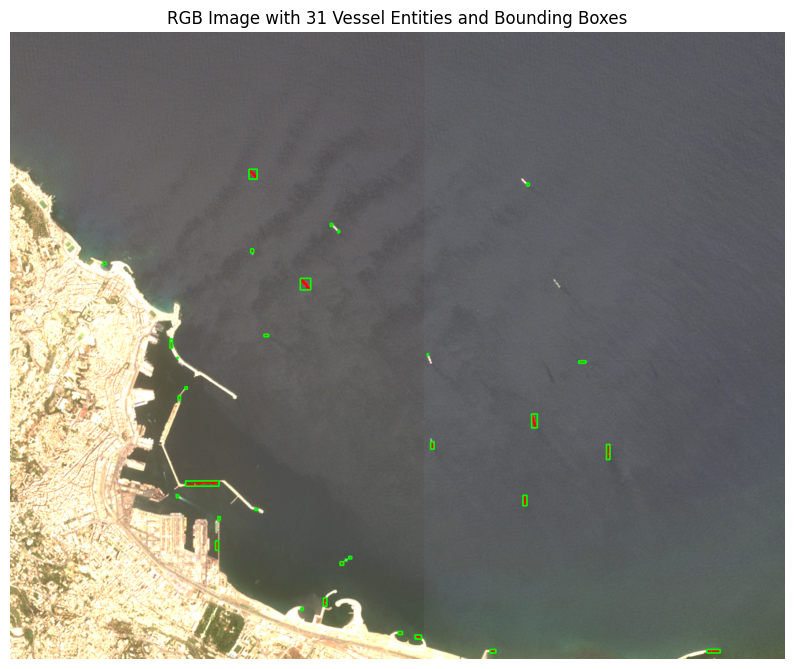

Number of Vessel Entities: 31


In [1]:
from inference_notebook_support import *

dataset_folder = 'validation_data/'

threshold = 0.5
ship_detector(dataset_folder,threshold, file_format="gtiff", segmentation = True)


Example for netCDF format : 

Raw shape of the dataset was (703, 983, 6)
New shape is (640, 960)
150/150 [===========================]


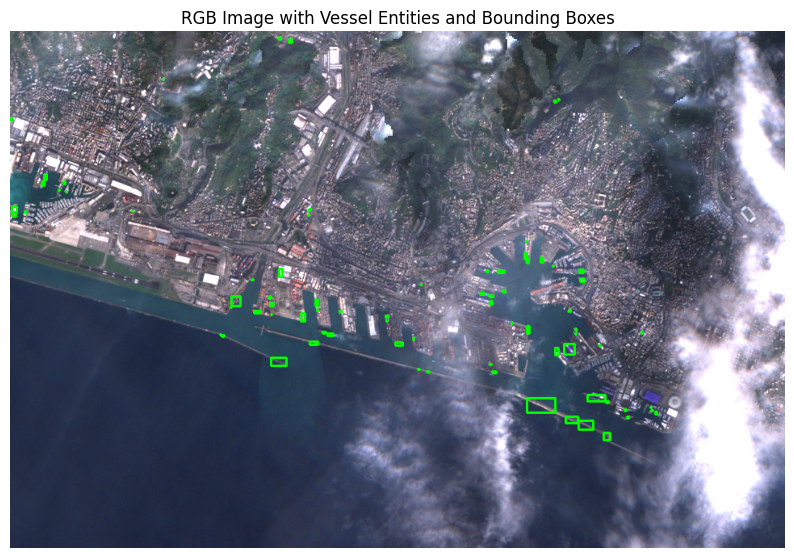

In [2]:
from inference_notebook_support import *

dataset_folder = 'validation_data/openEO.nc'

threshold = 0.75
ship_detector(dataset_folder,threshold, file_format="netcdf")